In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#loading dataset
retail = pd.read_csv("online_retail.csv", encoding='ISO-8859-1')
print(retail.tail())

         index InvoiceNo StockCode                      Description  Quantity  \
541904  541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905  541905    581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
541906  541906    581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
541907  541907    581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
541908  541908    581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerID Country  
541904  12/9/2011 12:50       0.85     12680.0  France  
541905  12/9/2011 12:50       2.10     12680.0  France  
541906  12/9/2011 12:50       4.15     12680.0  France  
541907  12/9/2011 12:50       4.15     12680.0  France  
541908  12/9/2011 12:50       4.95     12680.0  France  


In [2]:
#basic cleaning
#dropping rows with missing customerID
retail.dropna(subset=['CustomerID'], inplace=True)
#removing cancelled transactions
retail = retail[~retail['InvoiceNo'].astype(str).str.startswith('C')]
#removing extra spaces from descriptions
retail['Description'] = retail['Description'].str.strip()
#filter for france only (its a very large dataset..)
france_subset = retail[retail['Country'] == "France"]

print(f"Total Transactions: {retail.shape[0]}")
print(f"France Transactions: {france_subset.shape[0]}")
print(france_subset.head()) 

Total Transactions: 397924
France Transactions: 8342
    index InvoiceNo StockCode                      Description  Quantity  \
26     26    536370     22728        ALARM CLOCK BAKELIKE PINK        24   
27     27    536370     22727         ALARM CLOCK BAKELIKE RED        24   
28     28    536370     22726       ALARM CLOCK BAKELIKE GREEN        12   
29     29    536370     21724  PANDA AND BUNNIES STICKER SHEET        12   
30     30    536370     21883                  STARS GIFT TAPE        24   

       InvoiceDate  UnitPrice  CustomerID Country  
26  12/1/2010 8:45       3.75     12583.0  France  
27  12/1/2010 8:45       3.75     12583.0  France  
28  12/1/2010 8:45       3.75     12583.0  France  
29  12/1/2010 8:45       0.85     12583.0  France  
30  12/1/2010 8:45       0.65     12583.0  France  


In [3]:
#creating basket matrix
basket = (france_subset.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

#conerting to binary
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket.map(encode_units)
basket_sets = basket.applymap(encode_units) 

#dropping the 'Postage' column as it is usually a line item, not a real product
if 'POSTAGE' in france_subset.columns:
    basket_sets.drop('POSTAGE', inplace=True, axis=1)
print((f"Matrix Shape: {basket_sets.shape}"))
print(basket_sets.head()) 

Matrix Shape: (389, 1543)
Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
InvoiceNo                                                         
536370                            0                           0   
536852                            0                           0   
536974                            0                           0   
537065                            0                           0   
537463                            0                           0   

Description  12 EGG HOUSE PAINTED WOOD  12 MESSAGE CARDS WITH ENVELOPES  \
InvoiceNo                                                                 
536370                               0                                0   
536852                               0                                0   
536974                               0                                0   
537065                               0                                0   
537463                               0                

In [4]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
#finding frequent itemsets
#min_support=0.07 means items that appear in at least 7% of txns
#use_colnames=True gives actual product names
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

#sorting by support (most popular items first)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
print(f"Found {frequent_itemsets.shape[0]} frequent itemsets.")
print(frequent_itemsets.sort_values(by='support', ascending=False).head()) 

Found 90 frequent itemsets.
     support                            itemsets  length
22  0.771208                           (POSTAGE)       1
23  0.187661                (RABBIT NIGHT LIGHT)       1
27  0.179949     (RED TOADSTOOL LED NIGHT LIGHT)       1
21  0.172237  (PLASTERS IN TIN WOODLAND ANIMALS)       1
18  0.169666     (PLASTERS IN TIN CIRCUS PARADE)       1


c:\Users\USER\AppData\Local\Programs\Python\Python314\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [5]:
#generating rules (confidence and lift)
#metric="lift": rules where the link is stronger than random chance
#min_threshold=1: keeping positive associations
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1) 

In [6]:
#sorting by the strongest connection (lift)
rules =  rules.sort_values(by='lift', ascending=False)

In [7]:
#cleaning up display by showing only key columns 
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)) 

                                           antecedents  \
79                          (ALARM CLOCK BAKELIKE RED)   
78               (ALARM CLOCK BAKELIKE GREEN, POSTAGE)   
3                           (ALARM CLOCK BAKELIKE RED)   
2                         (ALARM CLOCK BAKELIKE GREEN)   
77                 (ALARM CLOCK BAKELIKE RED, POSTAGE)   
80                        (ALARM CLOCK BAKELIKE GREEN)   
7                          (ALARM CLOCK BAKELIKE PINK)   
6                           (ALARM CLOCK BAKELIKE RED)   
118  (SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...   
123                    (SET/6 RED SPOTTY PAPER PLATES)   

                                           consequents   support  confidence  \
79               (ALARM CLOCK BAKELIKE GREEN, POSTAGE)  0.071979    0.756757   
78                          (ALARM CLOCK BAKELIKE RED)  0.071979    0.848485   
3                         (ALARM CLOCK BAKELIKE GREEN)  0.079692    0.837838   
2                           (ALARM CLOCK 

In [13]:
#converting frozensets to strings for better readability
#converting apriori to plain tex: "Item"
rules['ant_str'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['con_str'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

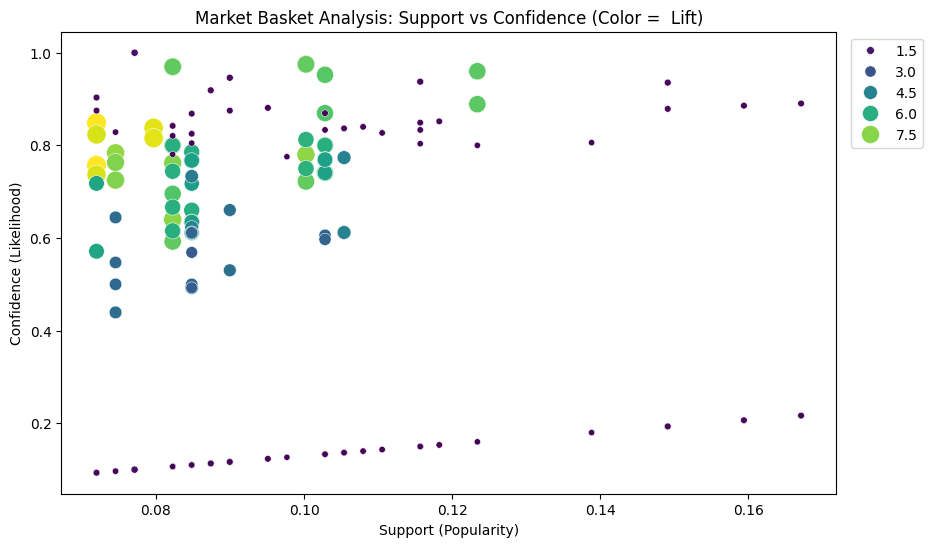

In [14]:
#visuals: scatter plots of all rules
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="support",
    y="confidence",
    size="lift",
    hue="lift",    data=rules,
    palette="viridis",
    sizes=(20, 200)
)

plt.title('Market Basket Analysis: Support vs Confidence (Color =  Lift)')
plt.xlabel('Support (Popularity)')
plt.ylabel('Confidence (Likelihood)')
plt.legend(bbox_to_anchor=(1.01, 1),
           loc='upper left')
plt.show()

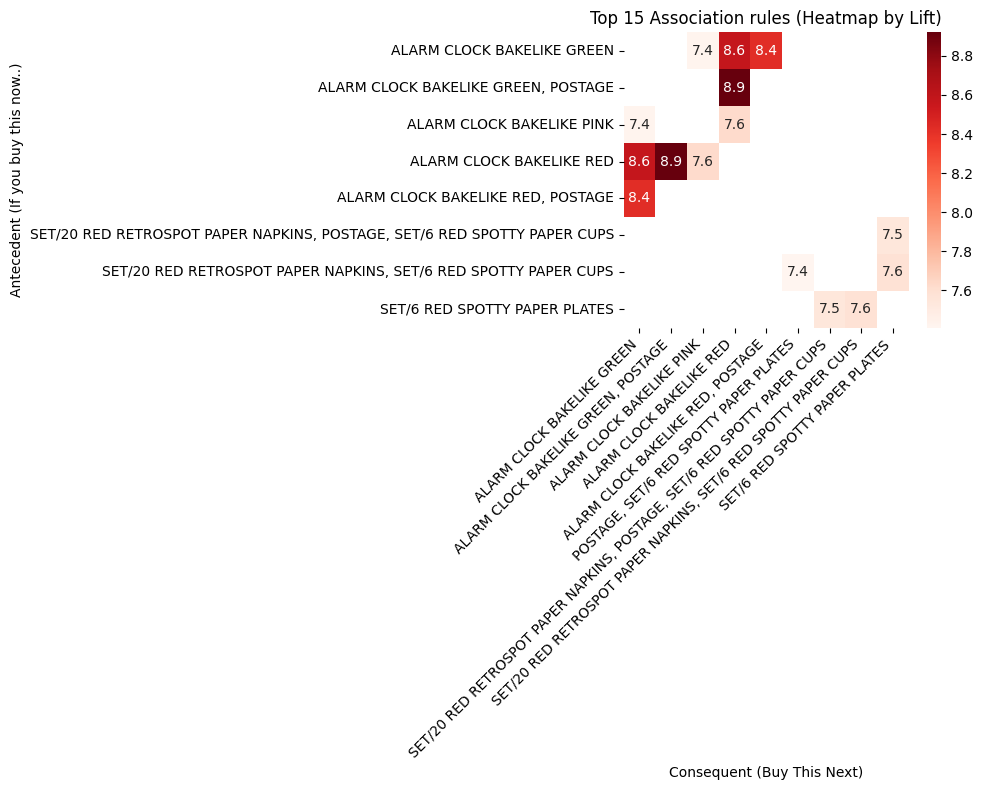

In [17]:
#visuals: Heatmap of the Top 15 Strongest Rules
#pivoting to data to create a matrix
#rows = Fist Item (Anecedent), Cols = Second Item (Consequent), Value = Lift
top_rules = rules.sort_values(by='lift', ascending=False).head(15)

#creating a matrix for the heatmap
pivot = top_rules.pivot(index='ant_str', columns='con_str', values='lift')

#visuals 
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True,
            cmap="Reds",
            fmt=".1f")
plt.title('Top 15 Association rules (Heatmap by Lift)')
plt.xlabel('Consequent (Buy This Next)')
plt.ylabel('Antecedent (If you buy this now..)')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() 